# Bayesian cluster expansions

Bayesian cluster expansions (CEs) are a flexible approach to infer physical knowledge about the system by formulating priors for the effective cluster interactions (ECIs) and including them in an inverse covariance matrix [Mueller and Ceder (2009)](https://doi.org/10.1103/PhysRevB.80.024103). 
Here, we showcase the use of Bayesian CEs for a low symmetry system, namely a surface slab, to couple similar orbits.
We will use a 10-layer surface slab of a Au-Pd alloys and use priors to couple orbits far from the surface. 
We refer to the [tutorial on customizing cluster spaces](customizing_cluster_spaces.ipynb) for an introduction on how to inspect a cluster space to figure out which orbits are far from the surface. 

A more comprehensive tutorial on Bayesian cluster expansions can be found [here](https://ce-tutorials.materialsmodeling.org/part-2/low-symmetry-ce.html#Bayesian-CE).

In the Bayesian cluster expansion (CE) framework, priors are formulated for the effective cluster interactions (ECI) and included in an inverse covariance matrix to infer physical knowledge about the system.
We use gaussian priors for the ECI on the form
$$
P(\vec{w}|\vec{X}) \propto \prod_\alpha e^{-w_\alpha^2/2\sigma_\alpha^2} \prod_{\alpha, \beta\neq\alpha} e^{-(w_\alpha-w_\beta)^2/2\sigma_{\alpha\beta}^2}.
$$
where $\vec{w}$ are the ECIs, $\vec{X}$ is the sensing matrix, $\sigma_\alpha$ is a regularization parameter for orbit $\alpha$ and $\sigma_{\alpha\beta}$ is a coupling strength between orbits $\alpha$ and $\beta$.
By tuning $\sigma_\alpha$ we can thus control the size of $w_\alpha$ while $\sigma_{\alpha\beta}$ controls the coupeling between two orbits such that a lower value will yield more similar ECI.

From here, we directly obtain the maximum likelihood estimate for the ECI via the `least-squares-with-reg-matrix` fit method implemented in `trainstation`. It would also be possible to formulate an expression for the posterior probability $P(\vec{w}|\vec{y}, \vec{X})$ that can e.g. be sampled with Markov chain Monte Carlo, but that is beyond the scope of this tutorial.

## Setting up a cluster space 

In this tutorial, we use a binary 10-layer surface slab as an example system and couple orbits of the same order and radius far from the surface, since these orbits should be similar to the corresponding orbit in a bulk system. 

In [1]:
from icet import ClusterSpace
from ase.build import fcc111

structure = fcc111('Au', size=(1, 1, 10), a=4.0, vacuum=10, periodic=True)

# Set up cluster space
cs = ClusterSpace(
    structure=structure,
    cutoffs=[3.0],
    chemical_symbols=['Au', 'Pd'])
display(cs)

Field,Value
Space group,P-3m1 (164)
Sublattice A,"('Au', 'Pd')"
Cutoffs,[3.0]
Total number of parameters,16
Number of parameters of order 0,1
Number of parameters of order 1,5
Number of parameters of order 2,10
fractional_position_tolerance,2e-06
position_tolerance,1e-05
symprec,1e-05


The ECIs correspond to the zerolet, 5 singlets and 10 nearest neightbor pairs. 

The system consists of 5 symmetrically inequivalent sites indexed such that site 0 is in the surface layer, site 1 in the subsurface, ..., and site 4 is in the middle of the slab.
We consider all orbits which include sites 0 and 1 to belong to the surface and all other orbits to be bulk orbits which should be coupled. 

We print the sites of all orbits to determine which orbits are bulk sites:

In [2]:
for i, orb in enumerate(cs.orbit_list):
    print(f'Orbit {i} sites: ', orb.sites)

Orbit 0 sites:  [0]
Orbit 1 sites:  [1]
Orbit 2 sites:  [2]
Orbit 3 sites:  [3]
Orbit 4 sites:  [4]
Orbit 5 sites:  [4, 5]
Orbit 6 sites:  [0, 0]
Orbit 7 sites:  [0, 1]
Orbit 8 sites:  [1, 1]
Orbit 9 sites:  [1, 2]
Orbit 10 sites:  [2, 2]
Orbit 11 sites:  [2, 3]
Orbit 12 sites:  [3, 3]
Orbit 13 sites:  [3, 4]
Orbit 14 sites:  [4, 4]


We find that the singlets corresponding to orbits 2-4 should be coupled as well as the pairs corresponding to orbits 5, 10-14 should be coupled. 

## Setting up the inverse covariance matrix

The inverse covariance matrix $\Lambda$ is a quadratic matrix with size determined by the number of ECIs. It has diagonal elements $\Lambda_{\alpha\alpha} = \frac{\sigma^2}{\sigma_\alpha^2} + \sum_{\beta\neq\alpha}\frac{\sigma^2}{\sigma_{\alpha\beta}^2}$ and off-diagonal elements $\Lambda_{\alpha\beta}=\Lambda_{\beta\alpha}=-\frac{\sigma^2}{\sigma_{\alpha\beta}^2}$,
where $\sigma$ is a scaling parameter reflecting the typical error of the model.

Note that the cluster space and orbit list indexing differ.
For a simple binary system, they differ by 1 due since the zerolet is not included in the orbit list.
For systems with more than two species, the difference will be more complex due to the inclusion of different multicomponent vectors in the cluster space but not the orbit list.
This is important since the indexing of the covariance matrix follows is the same as for the cluster space, so the orbit indices needs to be adjusted accordingly. 

Below we show how the inverse covariance matrix can be set up.

In [3]:
import numpy as np

# Helper function for setting up the inverse covariance matrix
def setup_inv_cov_matrix(ncols, orbits_to_couple, sigma_a, sigma_ab, sigma=1.0):
    # Fill diagnoal
    inv_cov = (sigma / sigma_a)**2 * np.eye(ncols)
    
    # Create list where each item is a list of similar orbits and loop over 
    similar = [[key] + val for (key, val) in orbits_to_couple.items()]
    for similar_indicies in similar:
        # Loop over the similar orbit indicies
        for ii, i in enumerate(similar_indicies):
            # Loop over the subsequent similar orbit indicies
            for j in similar_indicies[ii+1:]:
                # Now indicies i and j corresponds to two similar orbits
                
                # Change diagnoals ii and jj 
                # We need to add + 1 because the orbit list and cluster space
                # (=ECI) indexing differ by 1 due to the zerolet (which is not
                # included in the orbit list)
                inv_cov[i+1, i+1] += (sigma / sigma_ab)**2
                inv_cov[j+1, j+1] += (sigma / sigma_ab)**2
                
                # Change non-diagnoals ij and ji
                inv_cov[i+1, j+1] = - (sigma / sigma_ab)**2
                inv_cov[j+1, i+1] = - (sigma / sigma_ab)**2
    return inv_cov

# Number of parameters/columns of the sensing matrix
ncols = len(cs)

# Orbits to couple (any of the orbits can be the key)
orbits_to_couple = {2: [3, 4], 
                    5: [10, 11, 12, 13, 14]}

# Select values for sigma_a (regularization) and sigma_ab
# (coupling between orbits)
sigma_a = 10
sigma_ab = 0.01

# Setup inverse covariance matrix
inv_cov = setup_inv_cov_matrix(ncols, orbits_to_couple, sigma_a, sigma_ab)

## Training a cluster expansion

Next, we set up some random training data and train a cluster expansion using the inverse covariance matrix. 

**A very important consideration** if the coupled orbits have different multiplicities (as is the case here for orbit 5 vs. orbits 10-14) is how the multiplicities are treated.
In `icet`, multiplicites are included in the ECIs which means that the actual ECI of orbit 5 will be double the ECIs of orbits 10-14 if we simply continue to couple them.
To get around this, one need to either rescale the inverse covariance matrix or move the multiplicities to the sensing matrix during training and then move them back to the ECIs afterwards. Here chose the second approach. 

In [4]:
from icet import ClusterExpansion
from trainstation import CrossValidationEstimator

# Set up a random sensing matrix A and target vector y, these would
# normally be obtained by `A, y = StructureContainer.get_fit_data()`
A = np.random.random((20, ncols))
y = np.random.random(20)

# Get multiplicities and include them in sensing matrix
M = np.array(cs.get_multiplicities())
A_with_M = A*(M.T)

# Train using least squares
fit_kwargs = dict(reg_matrix = inv_cov)
opt = CrossValidationEstimator(fit_data=(A_with_M, y), 
                               fit_method='least-squares-with-reg-matrix', 
                               **fit_kwargs)
opt.validate()
opt.train()

parameters_wo_M = opt.parameters.copy()

# Multiply parameters with multiplicities
parameters_w_M = parameters_wo_M * M

# Finally, construct the CE
ce = ClusterExpansion(cluster_space=cs, parameters=parameters_w_M)

Lastly, we inspect the ECIs and find that orbits 2-4 as well as orbits 5, 10-14 have very similar values as intended. 

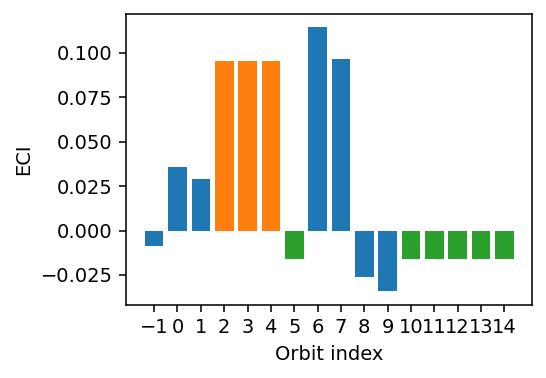

In [5]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(figsize=(4, 2.8), dpi=140)

ax.bar(range(-1, 15), parameters_wo_M)
ax.bar([2, 3, 4], [p for i, p in enumerate(parameters_wo_M) if i-1 in [2, 3, 4]])
ax.bar([5, 10, 11, 12, 13, 14], [p for i, p in enumerate(parameters_wo_M) 
                                 if i-1 in [5, 10, 11, 12, 13, 14]])

ax.set_xticks(range(-1, 15))
ax.set_ylabel('ECI')
ax.set_xlabel('Orbit index')

fig.tight_layout()